Bryan Jay - 260738764
### 2.2 Epipolar Geometry
SIFT POINTS

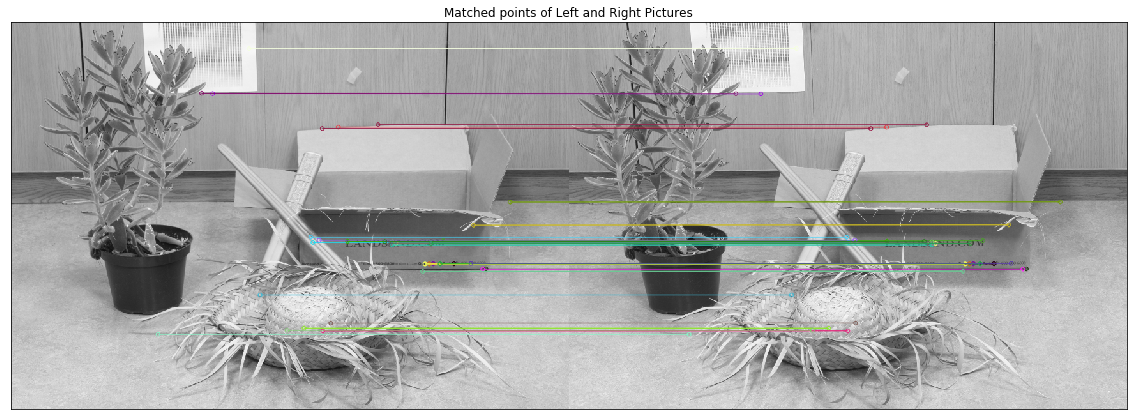

In [134]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

# # load left and right images
# imgR = cv2.imread("umbrella0.png")
# imgL = cv2.imread("umbrella1.png")

# # convert the images to colour RGB 
# imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
# imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# # copy the image
# imgL_dsp = imgL.copy()
# imgR_dsp = imgR.copy()

# # create a sift object 
# sift = cv2.xfeatures2d.SIFT_create()

# load left and right images
imgL = cv2.imread("swords0.png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("swords1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# copy the image
imgL_dsp = imgL.copy()
imgR_dsp = imgR.copy()

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
keypoints_imgL, descriptors_imgL = sift.detectAndCompute(imgL, None)
keypoints_imgR, descriptors_imgR = sift.detectAndCompute(imgR, None)


# draw the keypoints 
cv2.drawKeypoints(imgL, keypoints_imgL, imgL_dsp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgR, keypoints_imgR, imgR_dsp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Create a BFMatcher object and match the descriptors 
bf = cv2.BFMatcher()
matches = bf.match(descriptors_imgL,descriptors_imgR)

# Sort them by distance and draw all the matches
matches = sorted(matches, key=lambda match:match.distance)
matched_image12 = cv2.drawMatches(imgL, keypoints_imgL, imgR, keypoints_imgR, matches[:40], imgL, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(matched_image12)
plt.title('Matched points of Left and Right Pictures'), plt.xticks([]), plt.yticks([])
plt.show()


Finding Epipolar Lines

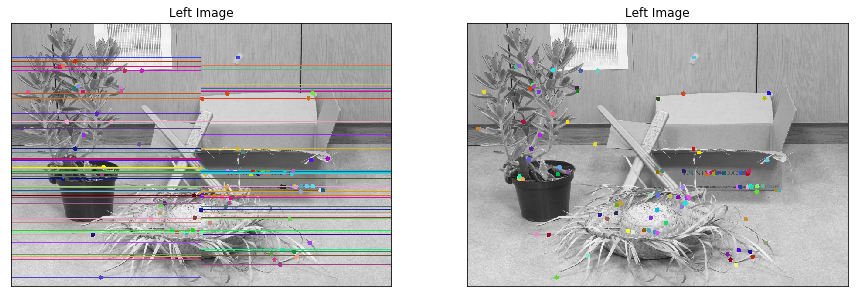

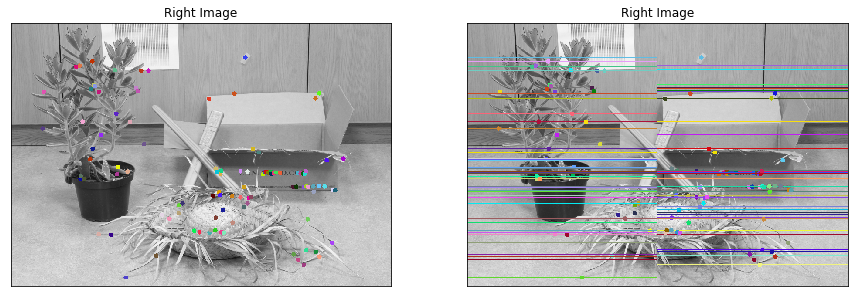

In [175]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgR = cv2.imread("swords0.png", cv2.IMREAD_GRAYSCALE)
imgL = cv2.imread("swords1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.4 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Picked any keypoint in the right image without a match in the left image

[ 92 211]
[[131 154 178 153 158]
 [131 165 170 106 170]
 [141 175 156  99 206]
 [155 173 148 153 238]
 [165 165 141 185 240]]


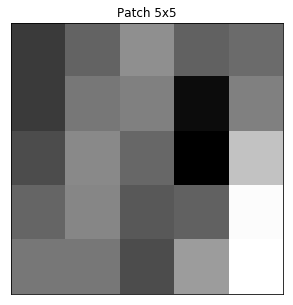

In [428]:
ptsL_bad = []
ptsR_bad = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.45 * n.distance and m.distance > 0.4 * n.distance:
#         if(kpR[m.trainIdx].pt not in ptsR):
        ptsR_bad.append(kpR[m.trainIdx].pt)
#         if(kpL[m.queryIdx].pt not in ptsL):
        ptsL_bad.append(kpL[m.queryIdx].pt)
        
# found a point where the Y pixels did not match for left and the right
index = 1
cPoint = np.array(ptsR_bad[index]).astype(int)
print(cPoint)

# get 5x5 patch by taking the top 3 and bottom 2 pixels and timilarly for the side
patch = imgR[cPoint[0]-3:cPoint[0]+2,cPoint[1]-3:cPoint[1]+2]

print(patch)
# display patch 
plt.figure(figsize=(5,5))
plt.subplot(111), plt.imshow(patch, cmap="gray")
plt.title("Patch 5x5"), plt.xticks([]), plt.yticks([])
plt.show()

Match the extracted patch using SSD with every patch on the line

In [429]:
# list containing all SSD values 
SSD = list()
# find the y values on the epipolar line and iterate accross it
Lpt = np.array(ptsL_bad[index]).astype(int)
print(Lpt)

y = Lpt[1]
for i in range(3, imgL.shape[0]-3):
    point = (i, y)
    patch_new = imgL[point[0]-3:point[0]+2, point[1]-3:point[1]+2]
    ssd_sum = np.sum((patch_new-patch)**2)
    SSD.append(ssd_sum)
    
print(min(SSD))

[ 46 213]
1449


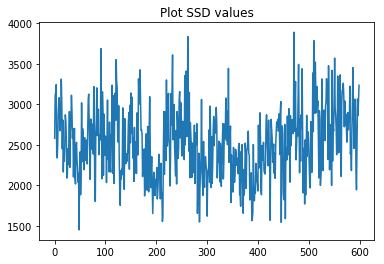

In [430]:
# plot the list onto the graph

plt.title("Plot SSD values")
plt.plot(SSD)
plt.show()

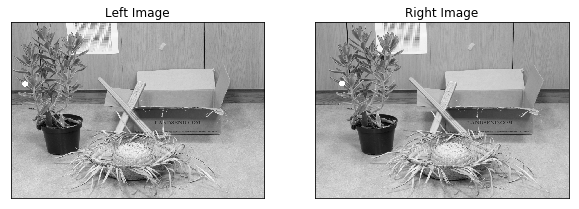

In [435]:
# copy the image
imgL_dsp = imgL.copy()
imgR_dsp = imgR.copy()

# find the point in the left image
min_index = np.argmin(SSD)
point = (min_index, y)

# put circles on display image
imgL_dsp = cv2.circle(imgL_dsp, (point[0], point[1]), 10, (255, 0, 0), -1)
imgR_dsp = cv2.circle(imgR_dsp, (cPoint[0], cPoint[1]), 10, (255, 0, 0), -1)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(imgL_dsp, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR_dsp, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one
Yes I found one pair however, there were many more possible pairs that could have been used to be matched. The match that was found was indeed a correct one but there were many possible points that could have been matched. Other matches could have been found becasue it is a tree like object therefore the texture of the tree is similar throughout the entire tree.

#### Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?
Possible constraits could have been sharpening ans smoothing in order in provide better edges. This is due to the fact that the location identified is a tree and if approach it by a certain edge we can get hopefully obtain a single match

#### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?
If the match had the lowest SSD then that would mean it was an outlier point potentially. A possible constraint could be a locality constraint that restricted that constricted the area of the image that would not allow the x and y coordinated to sway too much.